# SEOBNRv4CE Model Tutorial

This Jupyter Notebook provides a comprehensive tutorial on using the SEOBNRv4CE model for gravitational waveform generation and uncertainty quantification. The notebook is structured to guide users through the process of loading the GPR model, generating waveforms, and visualizing the difference between SEOBNRv4 and SEOBNRv4CE waveforms.

- Generate waveforms using SEOBNRv4CE
- Plot waveform differences between SEOBNRv4 and SEOBNRv4CE


In [1]:
import sys
import numpy as np
import lal
import lalsimulation as ls
import bilby

import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# Loading the GPR model
sys.path.append('/work/pi_gkhanna_uri_edu/riteshbachhar_uri_edu/Research/Packages/SEOBNRv4CE')
import seobnrv4ce
gpr_model_data_path = '/work/pi_gkhanna_uri_edu/riteshbachhar_uri_edu/Research/Packages/SEOBNRv4CE/data/uncertainty_interpolation_Mtot-50_fmin-20.0.hdf5'

# Setting the LAL_DATA_PATH
import os
os.environ["LAL_DATA_PATH"] = "/work/pi_gkhanna_uri_edu/riteshbachhar_uri_edu/Research/Packages/lal_data/"

from scripts.bilby_analyze_injection import setup_waveform_generator_standard

In [2]:
# Helper functions
def draw_seobnrv4ce_wrapper(frequency_array, injection_parameters, eps=None, zero=False):
    """
    Generates a gravitational waveform using the SEOBNRv4CE model with optional uncertainty parameters.

    Parameters:
    frequency_array (numpy.ndarray): Array of frequency values at which the waveform is evaluated.
    injection_parameters (dict): Dictionary containing the injection parameters for the waveform.
    eps (numpy.ndarray, optional): Array of uncertainty parameters. If None, random normal values are used. If zero is True, an array of zeros is used. Default is None.
    zero (bool, optional): If True, sets eps to an array of zeros. Default is False.

    Returns:
    numpy.ndarray: A complex array representing the gravitational waveform.
    """
    if eps is None:
        eps = np.zeros(20) if zero else np.random.normal(size=20)
    A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, P1, P2, P3, P4, P5, P6, P7, P8, P9, P10 = eps
    p = injection_parameters

    pol = seobnrv4ce.lal_binary_black_hole_with_waveform_uncertainty(
            frequency_array,
            p['mass_1'],
            p['mass_2'],
            p['luminosity_distance'],
            p['a_1'],
            p['tilt_1'],
            p['phi_12'],
            p['a_2'],
            p['tilt_2'],
            p['phi_jl'],
            p['theta_jn'],
            p['phase'],
            A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, P1, P2, P3, P4, P5, P6, P7, P8, P9, P10, 
            **waveform_arguments)
    return pol['plus'] + 1j * pol['cross']

# Get d_amp, d_phi
def get_damp_dphi(frequency_array, h, href, fmin=20.0, fmax=512.0):
    mask = (frequency_array >= fmin) & (frequency_array <= fmax)
    freq = frequency_array[mask]
    wf_frac = h[mask]/href[mask]
    damp = np.abs(wf_frac) - 1
    dphi = np.angle(wf_frac)
    return freq, damp, dphi

### Setup SEOBNRv4CE model

In [3]:
# Injection parameters
distance = 205.0

injection_parameters = dict(
        mass_1=40.840315, mass_2=33.257586, a_1=0.32, a_2=-0.57, tilt_1=0.0, tilt_2=0.0,
        phi_12=0.0, phi_jl=0.0, luminosity_distance=distance, theta_jn=2.83701491, psi=1.42892206,
        phase=1.3, geocent_time=1126259462.0, ra=-1.26157296, dec=1.94972503
    )
injection_parameters['chirp_mass'] = bilby.gw.conversion.component_masses_to_chirp_mass(injection_parameters['mass_1'], injection_parameters['mass_2'])
injection_parameters['mass_ratio'] = injection_parameters['mass_2'] / injection_parameters['mass_1']

# Setup the uncertainty model
minimum_frequency = 20.0
reference_frequency = minimum_frequency

waveform_approximant = 'SEOBNRv4_ROM'
waveform_arguments = dict(waveform_approximant=waveform_approximant, 
    reference_frequency=reference_frequency, minimum_frequency=minimum_frequency)
wferr = seobnrv4ce.WaveformUncertaintyInterpolation()
wferr.load_interpolation(gpr_model_data_path)
waveform_arguments['waveform_error_model'] = wferr

#### Waveform examples from SEOBNRv4CE model

20:17 bilby WARNING : There are unused waveform kwargs. This is deprecated behavior and will
result in an error in future releases. Make sure all of the waveform kwargs are correctly
spelled.

Unused waveform_kwargs: {'waveform_error_model': {}}

20:17 bilby WARNING : There are unused waveform kwargs. This is deprecated behavior and will
result in an error in future releases. Make sure all of the waveform kwargs are correctly
spelled.

Unused waveform_kwargs: {'waveform_error_model': {}}

20:17 bilby WARNING : There are unused waveform kwargs. This is deprecated behavior and will
result in an error in future releases. Make sure all of the waveform kwargs are correctly
spelled.

Unused waveform_kwargs: {'waveform_error_model': {}}

20:17 bilby WARNING : There are unused waveform kwargs. This is deprecated behavior and will
result in an error in future releases. Make sure all of the waveform kwargs are correctly
spelled.

Unused waveform_kwargs: {'waveform_error_model': {}}

20:17 bilby 

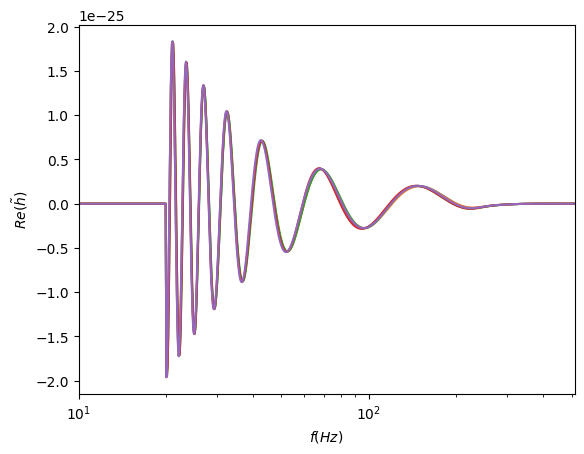

In [4]:
frequency_array = np.linspace(0, 512.0, 5000)

for _ in range(5):
    h_CE = draw_seobnrv4ce_wrapper(frequency_array, injection_parameters, zero=False)
    plt.semilogx(frequency_array, np.real(h_CE));

plt.xlim([10, 512]);
plt.xlabel('$f(Hz)$');
plt.ylabel(r'$Re(\tilde{h})$');

#### Waveform differences between SEOBNRv4 and SEOBNRv4CE

In [5]:
# SEOBNRv4 Waveform
eob_wf_gen = setup_waveform_generator_standard('SEOBNRv4_ROM', 20.0, 20.0, 4.0, 2048.0)
pol = eob_wf_gen.frequency_domain_strain(injection_parameters)
h_eob = pol['plus'] + 1j * pol['cross']
frequency_array = eob_wf_gen.frequency_array

# SEOBNRv4CE0 Waveform
h_CE_0 = draw_seobnrv4ce_wrapper(frequency_array, injection_parameters, zero=True)
freq, damp_0, dphi_0 = get_damp_dphi(frequency_array, h_CE_0, h_eob)

20:17 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
20:17 bilby WARNING : There are unused waveform kwargs. This is deprecated behavior and will
result in an error in future releases. Make sure all of the waveform kwargs are correctly
spelled.

Unused waveform_kwargs: {'waveform_error_model': {}}



20:17 bilby WARNING : There are unused waveform kwargs. This is deprecated behavior and will
result in an error in future releases. Make sure all of the waveform kwargs are correctly
spelled.

Unused waveform_kwargs: {'waveform_error_model': {}}

20:17 bilby WARNING : There are unused waveform kwargs. This is deprecated behavior and will
result in an error in future releases. Make sure all of the waveform kwargs are correctly
spelled.

Unused waveform_kwargs: {'waveform_error_model': {}}

20:17 bilby WARNING : There are unused waveform kwargs. This is deprecated behavior and will
result in an error in future releases. Make sure all of the waveform kwargs are correctly
spelled.

Unused waveform_kwargs: {'waveform_error_model': {}}

20:17 bilby WARNING : There are unused waveform kwargs. This is deprecated behavior and will
result in an error in future releases. Make sure all of the waveform kwargs are correctly
spelled.

Unused waveform_kwargs: {'waveform_error_model': {}}

20:17 bilby 

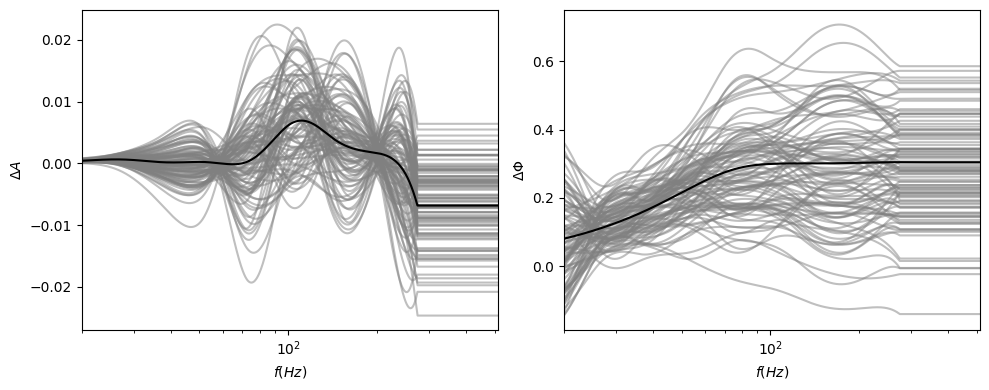

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for _ in range(100):
    h_CE = draw_seobnrv4ce_wrapper(frequency_array, injection_parameters, zero=False)
    freq, damp, dphi = get_damp_dphi(frequency_array, h_CE, h_eob)
    axs[0].semilogx(freq, damp, alpha=0.5, c='gray')
    axs[1].semilogx(freq, dphi, alpha=0.5, c='gray')

axs[0].semilogx(freq, damp_0, 'k', label='CE0')
axs[0].set_xlim([20, 512])
axs[0].set_xlabel('$f(Hz)$')
axs[0].set_ylabel('$\Delta A$')

axs[1].semilogx(freq, dphi_0, 'k', label='CE0')
axs[1].set_xlim([20, 512])
axs[1].set_xlabel('$f(Hz)$')
axs[1].set_ylabel('$\Delta \Phi$')

plt.tight_layout()
plt.show()